In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/planets-dataset/planet/planet/sample_submission.csv
/kaggle/input/planets-dataset/planet/planet/train_classes.csv
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_39140.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_4849.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_18979.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_24790.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_30624.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_7922.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_33905.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_15492.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_16642.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_37288.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_9357.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_40104.jpg
/kaggle/input/planets-dataset/planet/planet/test-jpg/test_1

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd
#import cv2, gc
import gc
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, InputLayer
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
import tensorflow as tf

import cv2
import os
from tqdm import tqdm

import time

from os import listdir
import csv

In [3]:
input_size = 128
epochs = 10
dropout_rate = 0.5
batch_size = 128
shape = (input_size, input_size, 3)
path = '../input/planets-dataset/planet/planet/'
train_path = '../input/planets-dataset/planet/planet/train-jpg'
test_path = '../input/planets-dataset/planet/planet/test-jpg'
lr = 0.0001
reg_str = 0.01 # Regularization Strength
nfolds = 2 # No of folds for cross validation
workers = 4 # Multithreading no of threads
maxq = 10 # Max Queue size for multithreading
tresh = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [4]:
df_train = pd.read_csv(f'{path}train_classes.csv')
df_test = pd.read_csv(f'{path}sample_submission.csv')

df_train['image_name'] = df_train['image_name'].astype(str) + '.jpg'
df_test['image_name'] = df_test['image_name'].astype(str) + '.jpg'

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

print(df_train.head())
print(df_test.head())

X_train_files = np.array(df_train['image_name'].tolist())
X_train_files.reshape((X_train_files.shape[0], 1))

y_train = np.array(df_train['tags'].tolist())

    image_name                                       tags
0  train_0.jpg                               haze primary
1  train_1.jpg            agriculture clear primary water
2  train_2.jpg                              clear primary
3  train_3.jpg                              clear primary
4  train_4.jpg  agriculture clear habitation primary road
   image_name                                        tags
0  test_0.jpg  [primary, clear, agriculture, road, water]
1  test_1.jpg  [primary, clear, agriculture, road, water]
2  test_2.jpg  [primary, clear, agriculture, road, water]
3  test_3.jpg  [primary, clear, agriculture, road, water]
4  test_4.jpg  [primary, clear, agriculture, road, water]


In [5]:
labels = []

for tag in df_train['tags'].values:
    labels_in_tag = tag.split(' ')
    for label in labels_in_tag:
        if label not in labels:
            labels.append(label)
        
labels.sort()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


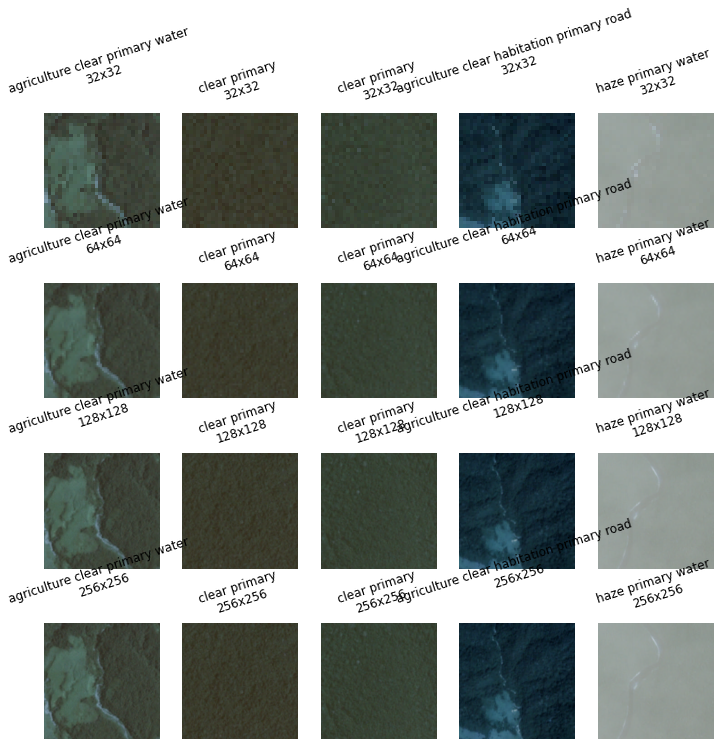

In [6]:
plt.figure(figsize=(12, 12))
res = [32, 64, 128, 256]
NIMGS = 5

for i in range(len(res)):
    for j in range(NIMGS):
        img = cv2.imread(os.path.join(train_path,df_train['image_name'][j+1]))
        img = cv2.resize(img, (res[i], res[i]))
        plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
        plt.imshow(img)
        plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]), rotation=18)
        plt.axis('off')
    
plt.show()

In [7]:
def create_model():
    model = Sequential()
    model.add(InputLayer(shape))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(17, activation='sigmoid'))
    return model

clear_session()

model = create_model()
model.summary()

2021-10-23 10:02:04.216310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 10:02:04.300770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 10:02:04.301571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 10:02:04.302941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              33558528  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________

In [9]:
def f2_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 5 * precision * recall / (4 * precision + recall)
    f_score = tf.where(tf.math.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [10]:
num_fold = 0

y_test = []
y_test2 = []

folds = KFold(n_splits=nfolds, shuffle=True, random_state=1).split(X_train_files, y_train)

for train_index, val_index in folds:
    X_train_files_fold = X_train_files[train_index]
    y_train_fold = y_train[train_index]
    X_val_files_fold = X_train_files[val_index]
    y_val_fold = np.array(y_train[val_index])
    
    train_df = pd.DataFrame(list(zip(X_train_files_fold, y_train_fold)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files_fold, y_val_fold)), columns = ['image_name', 'tags'])
    
    train_df['tags'] = train_df['tags'].apply(lambda x: x.split(' '))
    val_df['tags'] = val_df['tags'].apply(lambda x: x.split(' '))

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=train_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=test_path,
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )
    
    test_datagen2 = ImageDataGenerator(
        rescale=1./255
    )
    
    test_generator2 = test_datagen2.flow_from_dataframe(
        df_test,
        directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional",
        x_col='image_name',
        y_col='tags',
        target_size=(shape[0], shape[1]),
        class_mode='categorical',
        batch_size=batch_size,
        classes=labels,
        shuffle=False,
    )


    model_path_of_fold = os.path.join('', 'weights_of_fold_' + str(num_fold) + '.h5')
    
    clear_session()
    model = create_model()
    
    adam = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[f2_score])
    
    callbacks = [
        ModelCheckpoint(model_path_of_fold, monitor='val_f2_score', save_best_only=True, mode='max'),
        ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
    ]
    
    model.fit_generator(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks,
                       workers=workers, use_multiprocessing=True, max_queue_size=maxq)

    model.load_weights(model_path_of_fold)

    p_test = model.predict_generator(test_generator, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test.append(p_test)
    
    p_test2 = model.predict_generator(test_generator2, workers=workers, use_multiprocessing=True, max_queue_size=maxq)
    y_test2.append(p_test2)

Found 20239 validated image filenames belonging to 17 classes.
Found 20240 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 20522 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 40669 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 40669 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 20522 validated image filenames belonging to 17 classes.


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-23 10:04:04.739028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-10-23 10:04:10.552841: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


159/159 [==============================] - 216s 1s/step - loss: 0.2147 - f2_score: 0.6977 - val_loss: 0.1548 - val_f2_score: 0.8045
Epoch 2/10
159/159 [==============================] - 162s 1s/step - loss: 0.1546 - f2_score: 0.8021 - val_loss: 0.1481 - val_f2_score: 0.8450
Epoch 3/10
159/159 [==============================] - 164s 1s/step - loss: 0.1400 - f2_score: 0.8295 - val_loss: 0.1284 - val_f2_score: 0.8745
Epoch 4/10
159/159 [==============================] - 162s 1000ms/step - loss: 0.1287 - f2_score: 0.8501 - val_loss: 0.1239 - val_f2_score: 0.8633
Epoch 5/10
159/159 [==============================] - 163s 1s/step - loss: 0.1238 - f2_score: 0.8555 - val_loss: 0.1226 - val_f2_score: 0.8754
Epoch 6/10
159/159 [==============================] - 159s 984ms/step - loss: 0.1180 - f2_score: 0.8647 - val_loss: 0.1102 - val_f2_score: 0.8868
Epoch 7/10
159/159 [==============================] - 162s 1s/step - loss: 0.1144 - f2_score: 0.8683 - val_loss: 0.1035 - val_f2_score: 0.8917
Epo

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 20240 validated image filenames belonging to 17 classes.
Found 20239 validated image filenames belonging to 17 classes.
Found 40669 validated image filenames belonging to 17 classes.
Found 20522 validated image filenames belonging to 17 classes.
Epoch 1/10
159/159 [==============================] - 159s 981ms/step - loss: 0.2127 - f2_score: 0.6946 - val_loss: 0.1555 - val_f2_score: 0.8088
Epoch 2/10
159/159 [==============================] - 164s 1s/step - loss: 0.1524 - f2_score: 0.8009 - val_loss: 0.1386 - val_f2_score: 0.8474
Epoch 3/10
159/159 [==============================] - 157s 974ms/step - loss: 0.1369 - f2_score: 0.8323 - val_loss: 0.1269 - val_f2_score: 0.8524
Epoch 4/10
159/159 [==============================] - 163s 1s/step - loss: 0.1263 - f2_score: 0.8508 - val_loss: 0.1202 - val_f2_score: 0.8750
Epoch 5/10
159/159 [==============================] - 192s 1s/step - loss: 0.1188 - f2_score: 0.8604 - val_loss: 0.1092 - val_f2_score: 0.8839
Epoch 6/10
159/159 [=======

In [11]:
result1 = np.array(y_test[0])
for i in range(1, nfolds):
    result1 += np.array(y_test[i])
result1 /= nfolds
result1 = pd.DataFrame(result1, columns = labels)
result1.head()

agriculture  artisinal_mine  bare_ground  blooming  blow_down     clear  \
0     0.014331        0.000263     0.000718  0.040071   0.004765  0.996635   
1     0.015399        0.000663     0.000779  0.074135   0.004722  0.995729   
2     0.080419        0.001951     0.004083  0.002740   0.003347  0.002618   
3     0.677692        0.004343     0.041572  0.024815   0.030641  0.925579   
4     0.083364        0.002797     0.005692  0.001265   0.001714  0.003718   

     cloudy  conventional_mine  cultivation  habitation      haze  \
0  0.000098           0.000081     0.010786    0.001967  0.000659   
1  0.000099           0.000169     0.014969    0.002107  0.000615   
2  0.003671           0.000730     0.048036    0.007601  0.000905   
3  0.001059           0.002423     0.707801    0.056435  0.013371   
4  0.562786           0.002008     0.015603    0.006133  0.007679   

   partly_cloudy   primary      road  selective_logging  slash_burn     water  
0       0.005079  0.999874  0.007342           0.009208    0.000446  0.008530  
1       0.006944  0.999888  0.013265           0.025176    0.000590  0.009616  
2       0.996277  0.997022  0.030374           0.004747    0.004152  0.075514  
3       0.071864  0.998420  0.096537           0.043504    0.075742  0.068664  
4       0.695285  0.469802  0.023886           0.001512    0.001939  0.072242

In [12]:
result2 = np.array(y_test2[0])
for i in range(1, nfolds):
    result2 += np.array(y_test2[i])
result2 /= nfolds
result2 = pd.DataFrame(result2, columns = labels)
result2.head()

agriculture  artisinal_mine  bare_ground  blooming  blow_down     clear  \
0     0.017490        0.002047     0.001321  0.144941   0.007046  0.998004   
1     0.960910        0.001512     0.024926  0.000507   0.001700  0.026740   
2     0.703634        0.001437     0.009919  0.000590   0.000445  0.658500   
3     0.110849        0.003162     0.008519  0.002642   0.000940  0.993869   
4     0.078440        0.000526     0.003592  0.046446   0.010382  0.996776   

     cloudy  conventional_mine  cultivation  habitation      haze  \
0  0.000146           0.000386     0.014413    0.004863  0.000256   
1  0.001589           0.002624     0.191092    0.122541  0.004537   
2  0.001519           0.006156     0.045935    0.183007  0.214476   
3  0.000212           0.000807     0.048899    0.025404  0.004157   
4  0.000134           0.000159     0.071835    0.003791  0.001020   

   partly_cloudy   primary      road  selective_logging  slash_burn     water  
0       0.002811  0.999843  0.042966           0.086579    0.000821  0.026352  
1       0.984601  0.986902  0.405386           0.002109    0.008464  0.075003  
2       0.072926  0.980580  0.948370           0.003605    0.001227  0.548168  
3       0.003652  0.999301  0.246378           0.019758    0.000918  0.952643  
4       0.004168  0.999797  0.012183           0.015625    0.001931  0.015580

In [13]:
results = result1.append(result2, ignore_index=True)
results.shape

(61191, 17)

In [14]:
preds = []
for i in range(results.shape[0]):
    a = results.iloc[[i]]
    a = a.apply(lambda x: x > tresh, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [15]:
df_test['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
df_test.head()

image_name                                        tags
0     test_0  [primary, clear, agriculture, road, water]
1     test_1  [primary, clear, agriculture, road, water]
2     test_2  [primary, clear, agriculture, road, water]
3     test_3  [primary, clear, agriculture, road, water]
4     test_4  [primary, clear, agriculture, road, water]

In [16]:

df_test['tags'] = preds

In [17]:
fin = pd.DataFrame(df_test["image_name"])
fin.head()

image_name
0     test_0
1     test_1
2     test_2
3     test_3
4     test_4

In [18]:
fin["tags"] = preds
fin.head()

image_name                                   tags
0     test_0                          clear primary
1     test_1                          clear primary
2     test_2                  partly_cloudy primary
3     test_3  agriculture clear cultivation primary
4     test_4           cloudy partly_cloudy primary

In [19]:
fin.to_csv('Ebole_submission.csv', index=False)